In [1]:
import numpy as np
import scipy.linalg
import scipy.io
import itertools
import matplotlib.pyplot as plt

from qiskit.visualization import *
from qiskit.extensions import UnitaryGate

# custom utility functions
from util import *
from qetu import *
from tfim import *
from fermi_hubbard import *
from wmi_backend import *

### Single Trotter step

In [2]:
nqubits = 2
nsysqubits = 2*nqubits
μ = 0
u = 8
t = 1
delta_t = 1

#### Reference Hamiltonian

In [3]:
H_2 = np.zeros((2**nsysqubits, 2**nsysqubits), dtype = 'complex_')
H_3 = np.zeros((2**nsysqubits, 2**nsysqubits), dtype = 'complex_')

# I_{1,↑} ⊗ I_{2,↑} ⊗ ... ⊗ Z_{j,↑} ⊗ ... ⊗ I_{n,↑} ⊗ I_{1,↓} ⊗ I_{2,↓} ⊗ ... ⊗ Z_{j,↓} ⊗ ... ⊗ I_{n,↓}
for i in range(nqubits):
    H_2 += np.kron(np.kron(np.kron(np.kron(np.eye(2**i), (np.eye(2) - Z_gate)), np.eye(2**(nqubits-1))), (np.eye(2) - Z_gate)), np.eye(2**(nqubits-1-i)))
H_2 *= 1/8*u

sigma_plus = X_gate + 1j * Y_gate
sigma_minus = X_gate - 1j * Y_gate
# I_{1,↑} ⊗ I_{2,↑} ⊗ ... ⊗ I_{j-1,↑} ⊗ Σ+_{j,↑} ⊗ Σ-_{j+1,↑} ⊗ I_{j+2,↑} ⊗ ... ⊗ I_{n,↑} ⊗ I_{1,↓} ⊗ I_{2,↓} ⊗ ... ⊗ I_{n,↓} +    
# I_{1,↑} ⊗ I_{2,↑} ⊗ ... ⊗ I_{j-1,↑} ⊗ Σ-_{j,↑} ⊗ Σ+_{j+1,↑} ⊗ I_{j+2,↑} ⊗ ... ⊗ I_{n,↑} ⊗ I_{1,↓} ⊗ I_{2,↓} ⊗ ... ⊗ I_{n,↓} +
# I_{1,↑} ⊗ I_{2,↑} ⊗ ... ⊗ I_{n,↑} ⊗ I_{1,↓} ⊗ ... ⊗ I_{j-1,↓} ⊗ Σ+_{j,↓} ⊗ Σ-_{j+1,↓} ⊗ I_{j+2,↓} ⊗ ... ⊗ I_{n,↓} +  
# I_{1,↑} ⊗ I_{2,↑} ⊗ ... ⊗ I_{n,↑} ⊗ I_{1,↓} ⊗ ... ⊗ I_{j-1,↓} ⊗ Σ-_{j,↓} ⊗ Σ+_{j+1,↓} ⊗ I_{j+2,↓} ⊗ ... ⊗ I_{n,↓}           
for i in range(nqubits-1):
    H_3 += np.kron(np.kron(np.kron(np.eye(2**i), sigma_plus), sigma_minus), np.eye(2**(2*nqubits-2-i)))
    H_3 += np.kron(np.kron(np.kron(np.eye(2**i), sigma_minus), sigma_plus), np.eye(2**(2*nqubits-2-i)))
    H_3 += np.kron(np.kron(np.kron(np.eye(2**(nqubits+i)), sigma_plus), sigma_minus), np.eye(2**(nqubits-2-i)))
    H_3 += np.kron(np.kron(np.kron(np.eye(2**(nqubits+i)), sigma_minus), sigma_plus), np.eye(2**(nqubits-2-i)))
H_3 *= -t

H_FH = H_2 + H_3
#array_to_latex(expm(-1j*H_FH))

In [4]:
U_ref = expm(-1j*delta_t*H_FH)
V_ref = scipy.linalg.block_diag(U_ref.conjugate().transpose(), U_ref)

#### Construct controlled Trotter

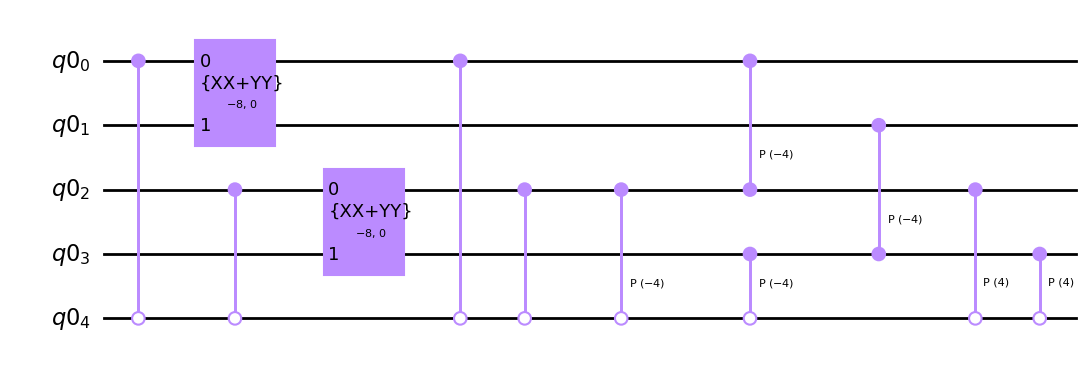

In [5]:
from qiskit.circuit.library import PhaseGate
from qiskit.quantum_info.operators import Operator

q = QuantumRegister(5)
qc_trotter = QuantumCircuit(q)

# calculate theta for XXPlusYY gate
theta = -8*t
beta = 0
#qc_trotter.barrier(q)
qc_trotter.cz(q[4], q[0], ctrl_state='0')
qc_trotter.cz(q[4], q[2], ctrl_state='0')
#qc_trotter.barrier(q)
qc_trotter.append(XXPlusYYGate(theta, beta), [0, 1])
qc_trotter.append(XXPlusYYGate(theta, beta), [2, 3])
#qc_trotter.barrier(q)
qc_trotter.cz(q[4], q[0], ctrl_state='0')
qc_trotter.cz(q[4], q[2], ctrl_state='0')
#qc_trotter.barrier(q)
# calculate lambda for CPhase gate
lam = -u*delta_t / (1*nqubits)
#qc_trotter.barrier(q)
# zero-controlled Phase Gate
zcp = PhaseGate(lam).control(1, ctrl_state='0')
qc_trotter.append(zcp, [4, 2])
qc_trotter.append(zcp, [4, 3])
#qc_trotter.barrier(q)
qc_trotter.cp(lam, q[0], q[2])
qc_trotter.cp(lam, q[1], q[3])
#qc_trotter.barrier(q)
zcp = PhaseGate(-lam).control(1, ctrl_state='0')
qc_trotter.append(zcp, [4, 2])
qc_trotter.append(zcp, [4, 3])
#qc_trotter.barrier(q)

qc_trotter.draw("mpl")

In [6]:
print("controlled Trotter error {:.5e}".format(np.linalg.norm(V_ref - get_matrix(qc_trotter), 2)))

controlled Trotter error 1.97872e+00


In [7]:
backend = FakeWMI()
noise_model = NoiseModel.from_backend(backend)
noise_model

<NoiseModel on ['sx', 'x', 'iswap', 'xx_plus_yy', 'y', 'cp', 'measure']>

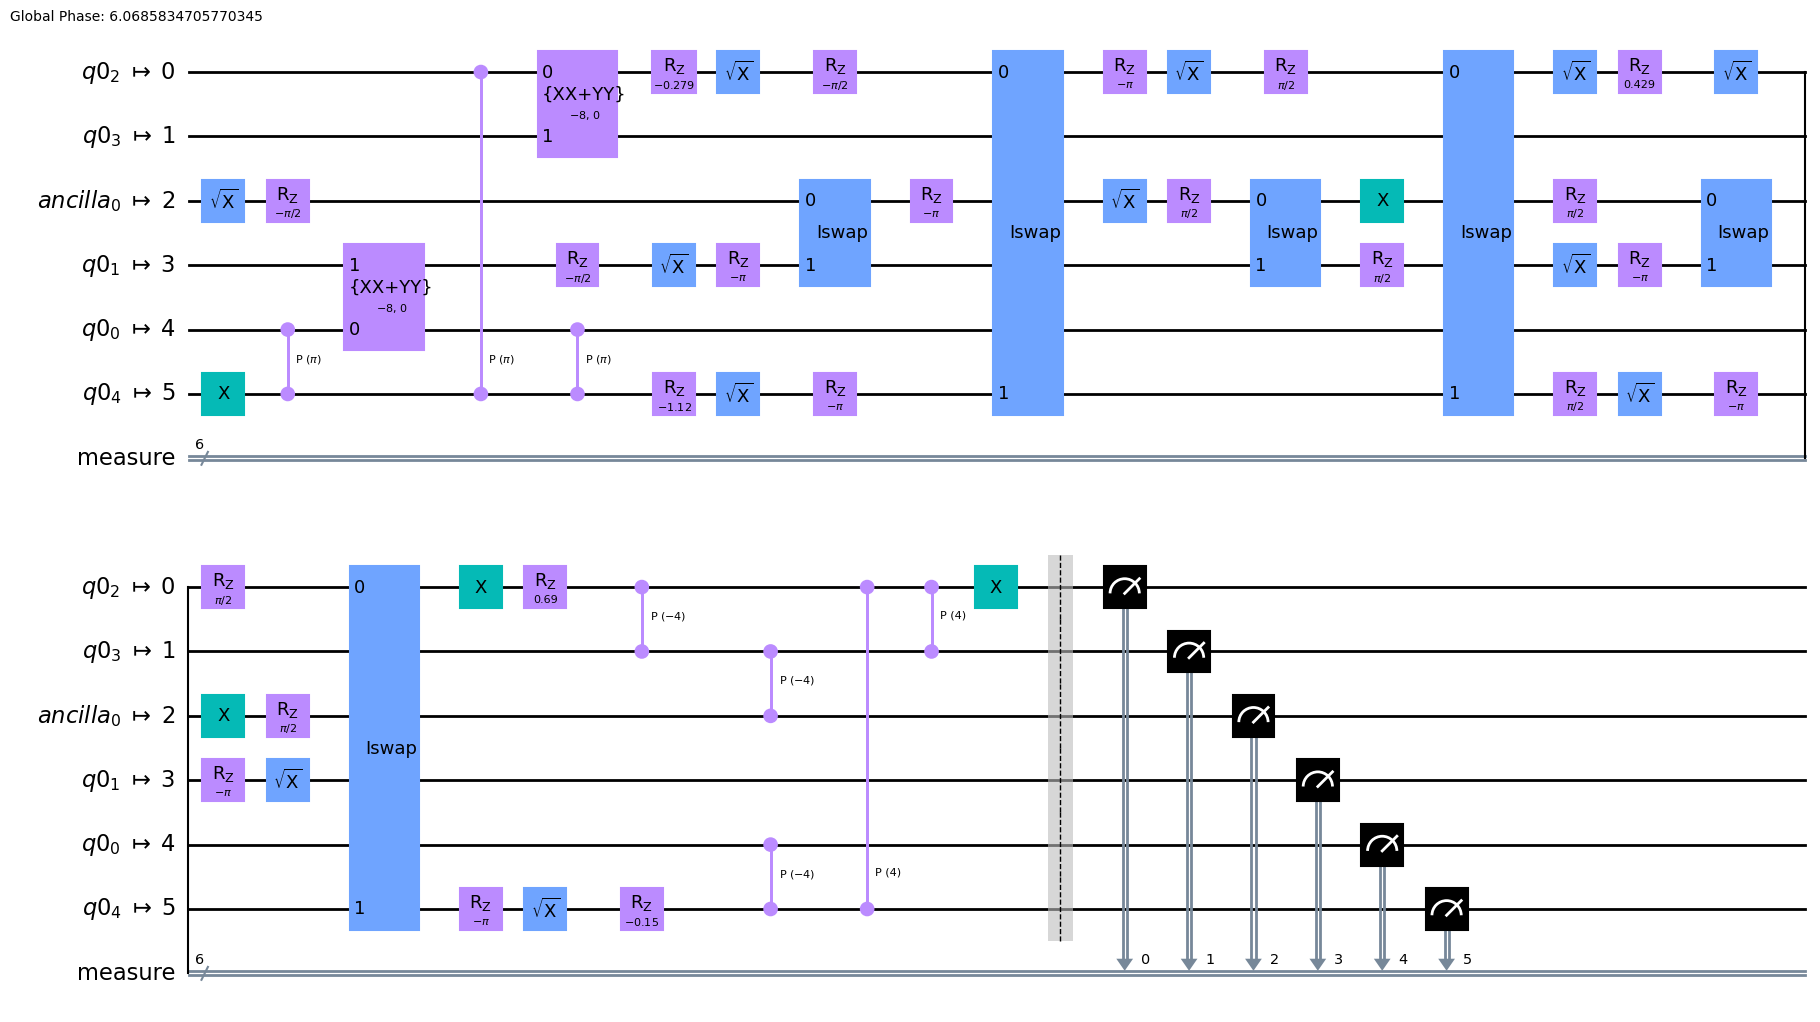

In [8]:
# Transpile to WMI hardware
test_circ = transpile(
    qc_trotter,
    backend=backend,
    optimization_level=3,
)
test_circ.measure_active()
test_circ.draw("mpl")

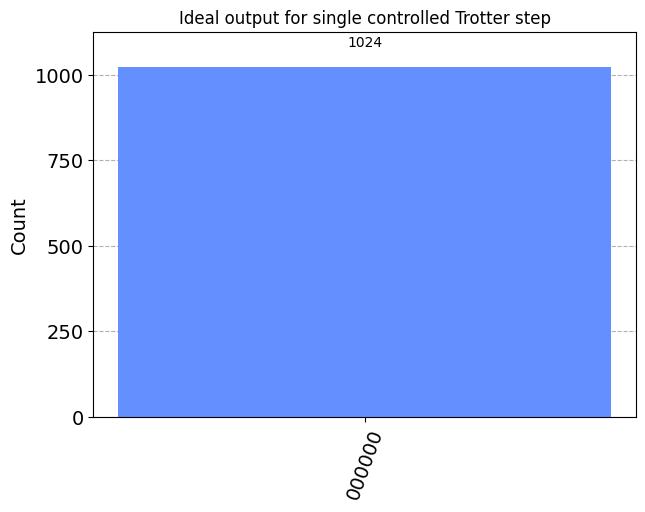

In [9]:
# Create ideal simulator backend and transpile circuit
sim_ideal = AerSimulator()
t_test_circ = transpile(test_circ, sim_ideal)

ideal_result = sim_ideal.run(t_test_circ).result()
ideal_counts = ideal_result.get_counts(0)
plot_histogram(ideal_counts,
               title='Ideal output for single controlled Trotter step')

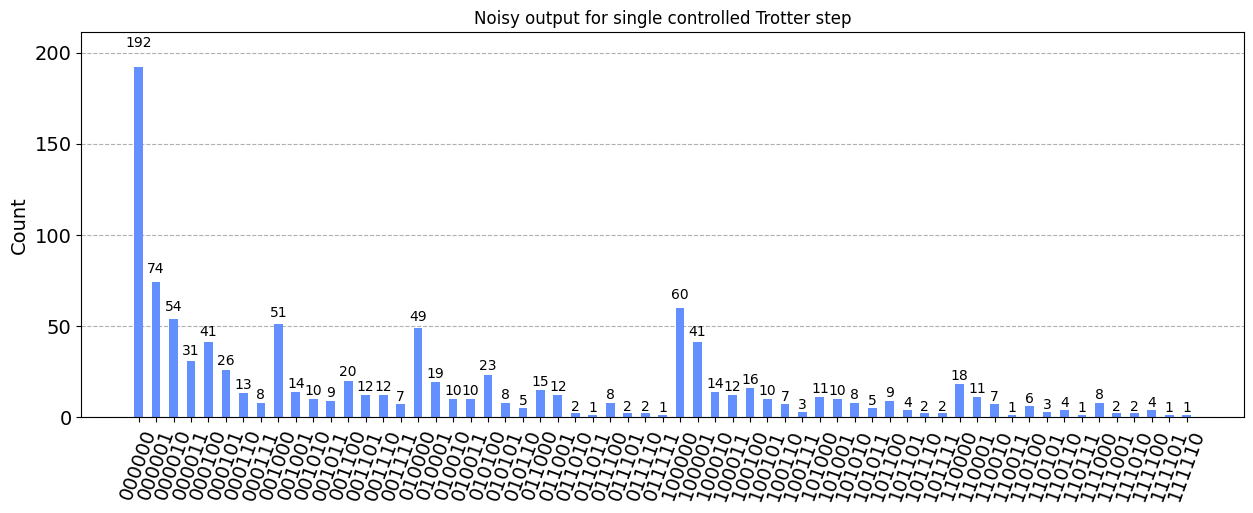

In [10]:
# Create noisy simulator and transpile circuit
wmi_backend = FakeWMI()
wmi_noise_model = NoiseModel.from_backend(wmi_backend)
wmi_noise_model.add_basis_gates(['unitary'])
sim_noise = AerSimulator(noise_model=wmi_noise_model)
test_circ = add_iswap_labels(test_circ)
test_circ = add_xx_plus_yy_labels(test_circ)
t_test_circ_noise = transpile(test_circ, sim_noise)

# Run on the simulator without noise
noise_result = sim_noise.run(t_test_circ_noise).result()
noise_counts = noise_result.get_counts(test_circ)
plot_histogram(noise_counts,
               title='Noisy output for single controlled Trotter step', figsize=(15,5))

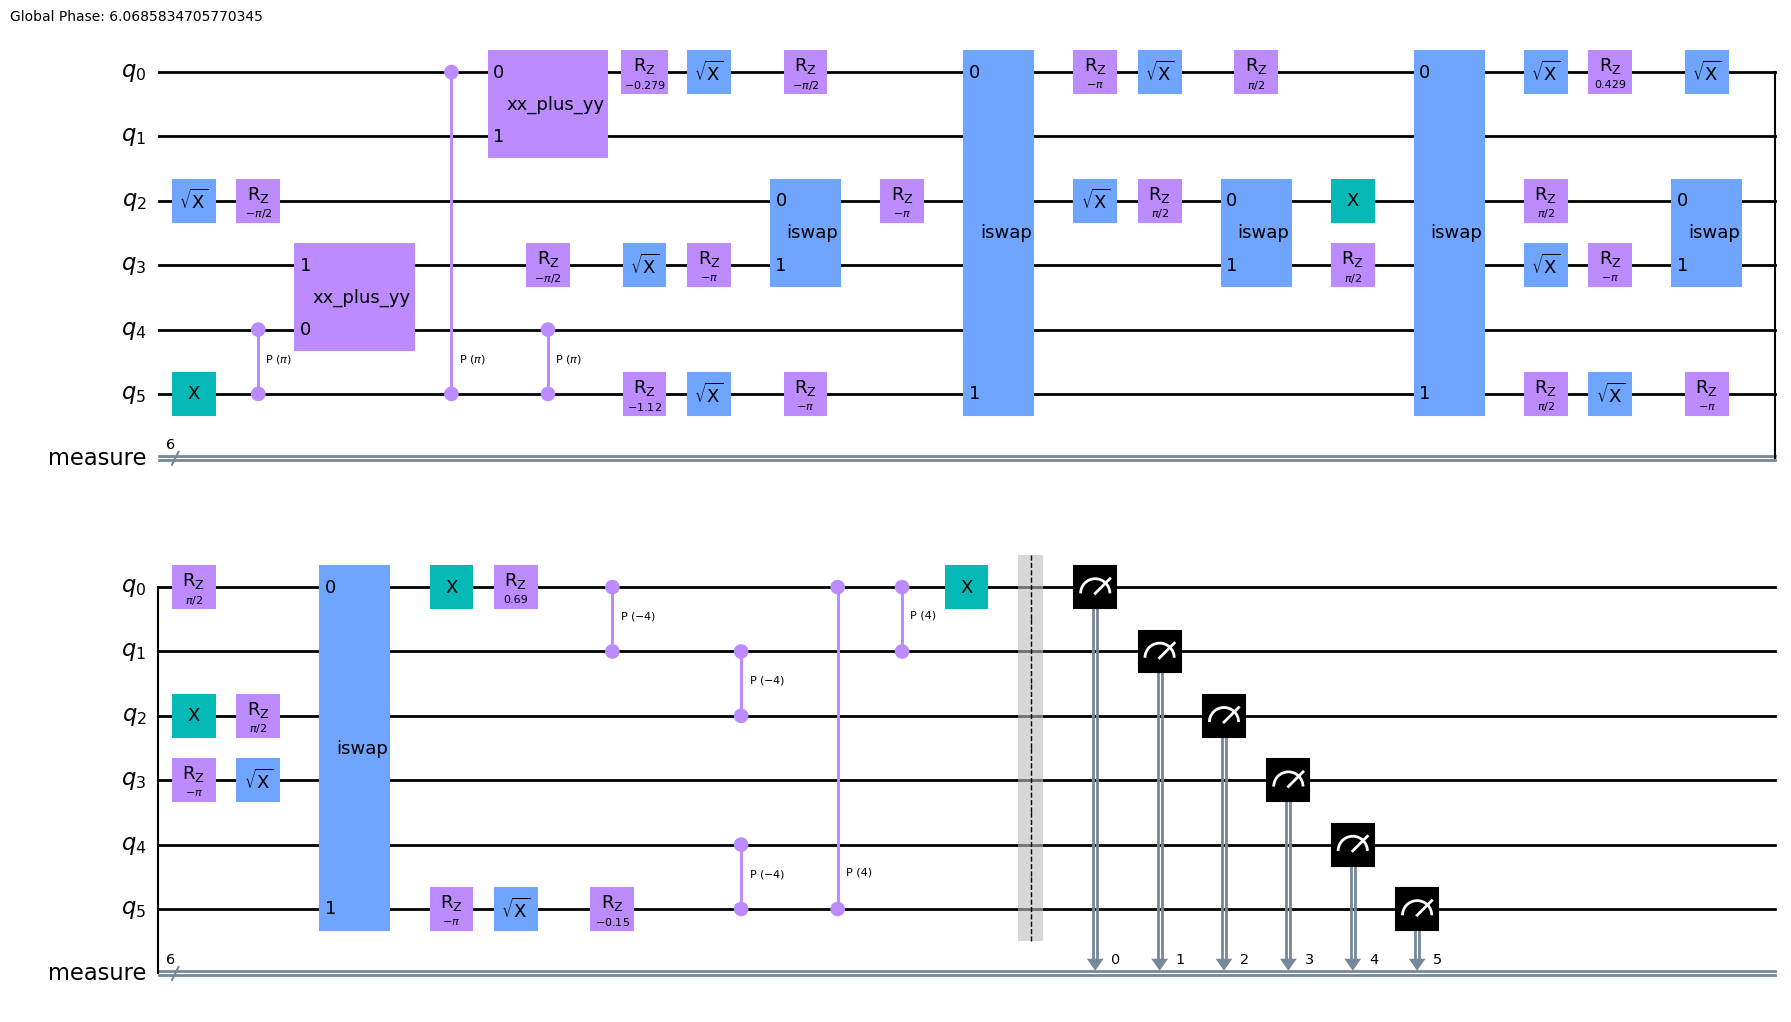

In [11]:
t_test_circ_noise.draw("mpl")

In [12]:
print(t_test_circ_noise.depth())

25


### QETU test

In [13]:
mat_step_func = scipy.io.loadmat('phase_angles/step_function.mat')['phi_proc']
step_function_qsp_angles = list(itertools.chain.from_iterable(mat_step_func))

mat_cheb_ex4 = scipy.io.loadmat('phase_angles/chebyshev_ex1.mat')['phi_proc']
cheb_ex4_qsp_angles = list(itertools.chain.from_iterable(mat_cheb_ex4))
cheb_ex4_qsp_angles = [0.5483, -0.6455, 0.5483]
print(cheb_ex4_qsp_angles)

[0.5483, -0.6455, 0.5483]


c:\Users\thilo\anaconda3\Lib\site-packages\scipy\io\matlab\_mio.py:227: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


actual eigenvalues: [-0.8520406   0.71173597  0.48214638  0.48214638  0.48214638  0.48214638
  0.8999681  -0.02767905 -0.1741722  -0.13094539  0.71173597 -0.8520406
  0.8999681   0.8999681   0.8999681  -0.86186298]


C:\Users\thilo\AppData\Roaming\Python\Python311\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\thilo\AppData\Roaming\Python\Python311\site-packages\matplotlib\collections.py:192: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


Text(0, 0.5, 'U = F(cos(λ))')

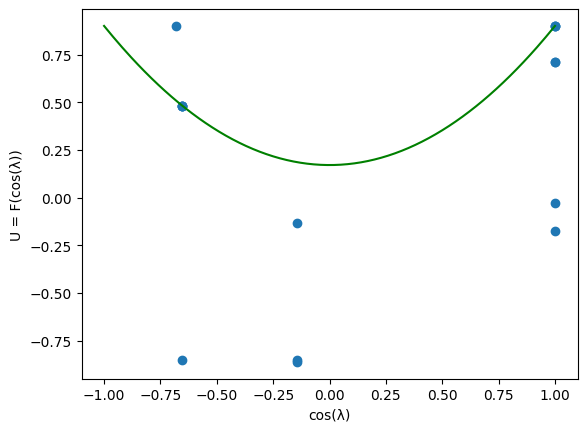

In [14]:
U_qc = QETU(qc_trotter, convert_Zrot_to_Xrot(cheb_ex4_qsp_angles))
U_qetu = get_matrix(U_qc)[0:16, 0:16]
λ = np.linalg.eigvals(H_FH)
#expected_eigenvalues = target_heaviside(np.cos(λ.real), 0.9)
#print("expected eigenvalues: " + str(expected_eigenvalues))
F_λ = np.linalg.eigvals(U_qetu).real * -1
print("actual eigenvalues: " + str(F_λ))

x_list = np.linspace(-1, 1, 201)
QSP_list = []
for x in x_list:
    QSP_circuit = QSP(cheb_ex4_qsp_angles, x)
    result = get_matrix(QSP_circuit)[0,0]
    QSP_list.append(result)

plt.plot(x_list, QSP_list, "g", label="Re[Poly(a)]")
#plt.scatter(x=np.cos(λ), y=expected_eigenvalues, color='r')
plt.scatter(x=np.cos(λ), y=F_λ)
plt.xlabel("cos(λ)")
plt.ylabel("U = F(cos(λ))")

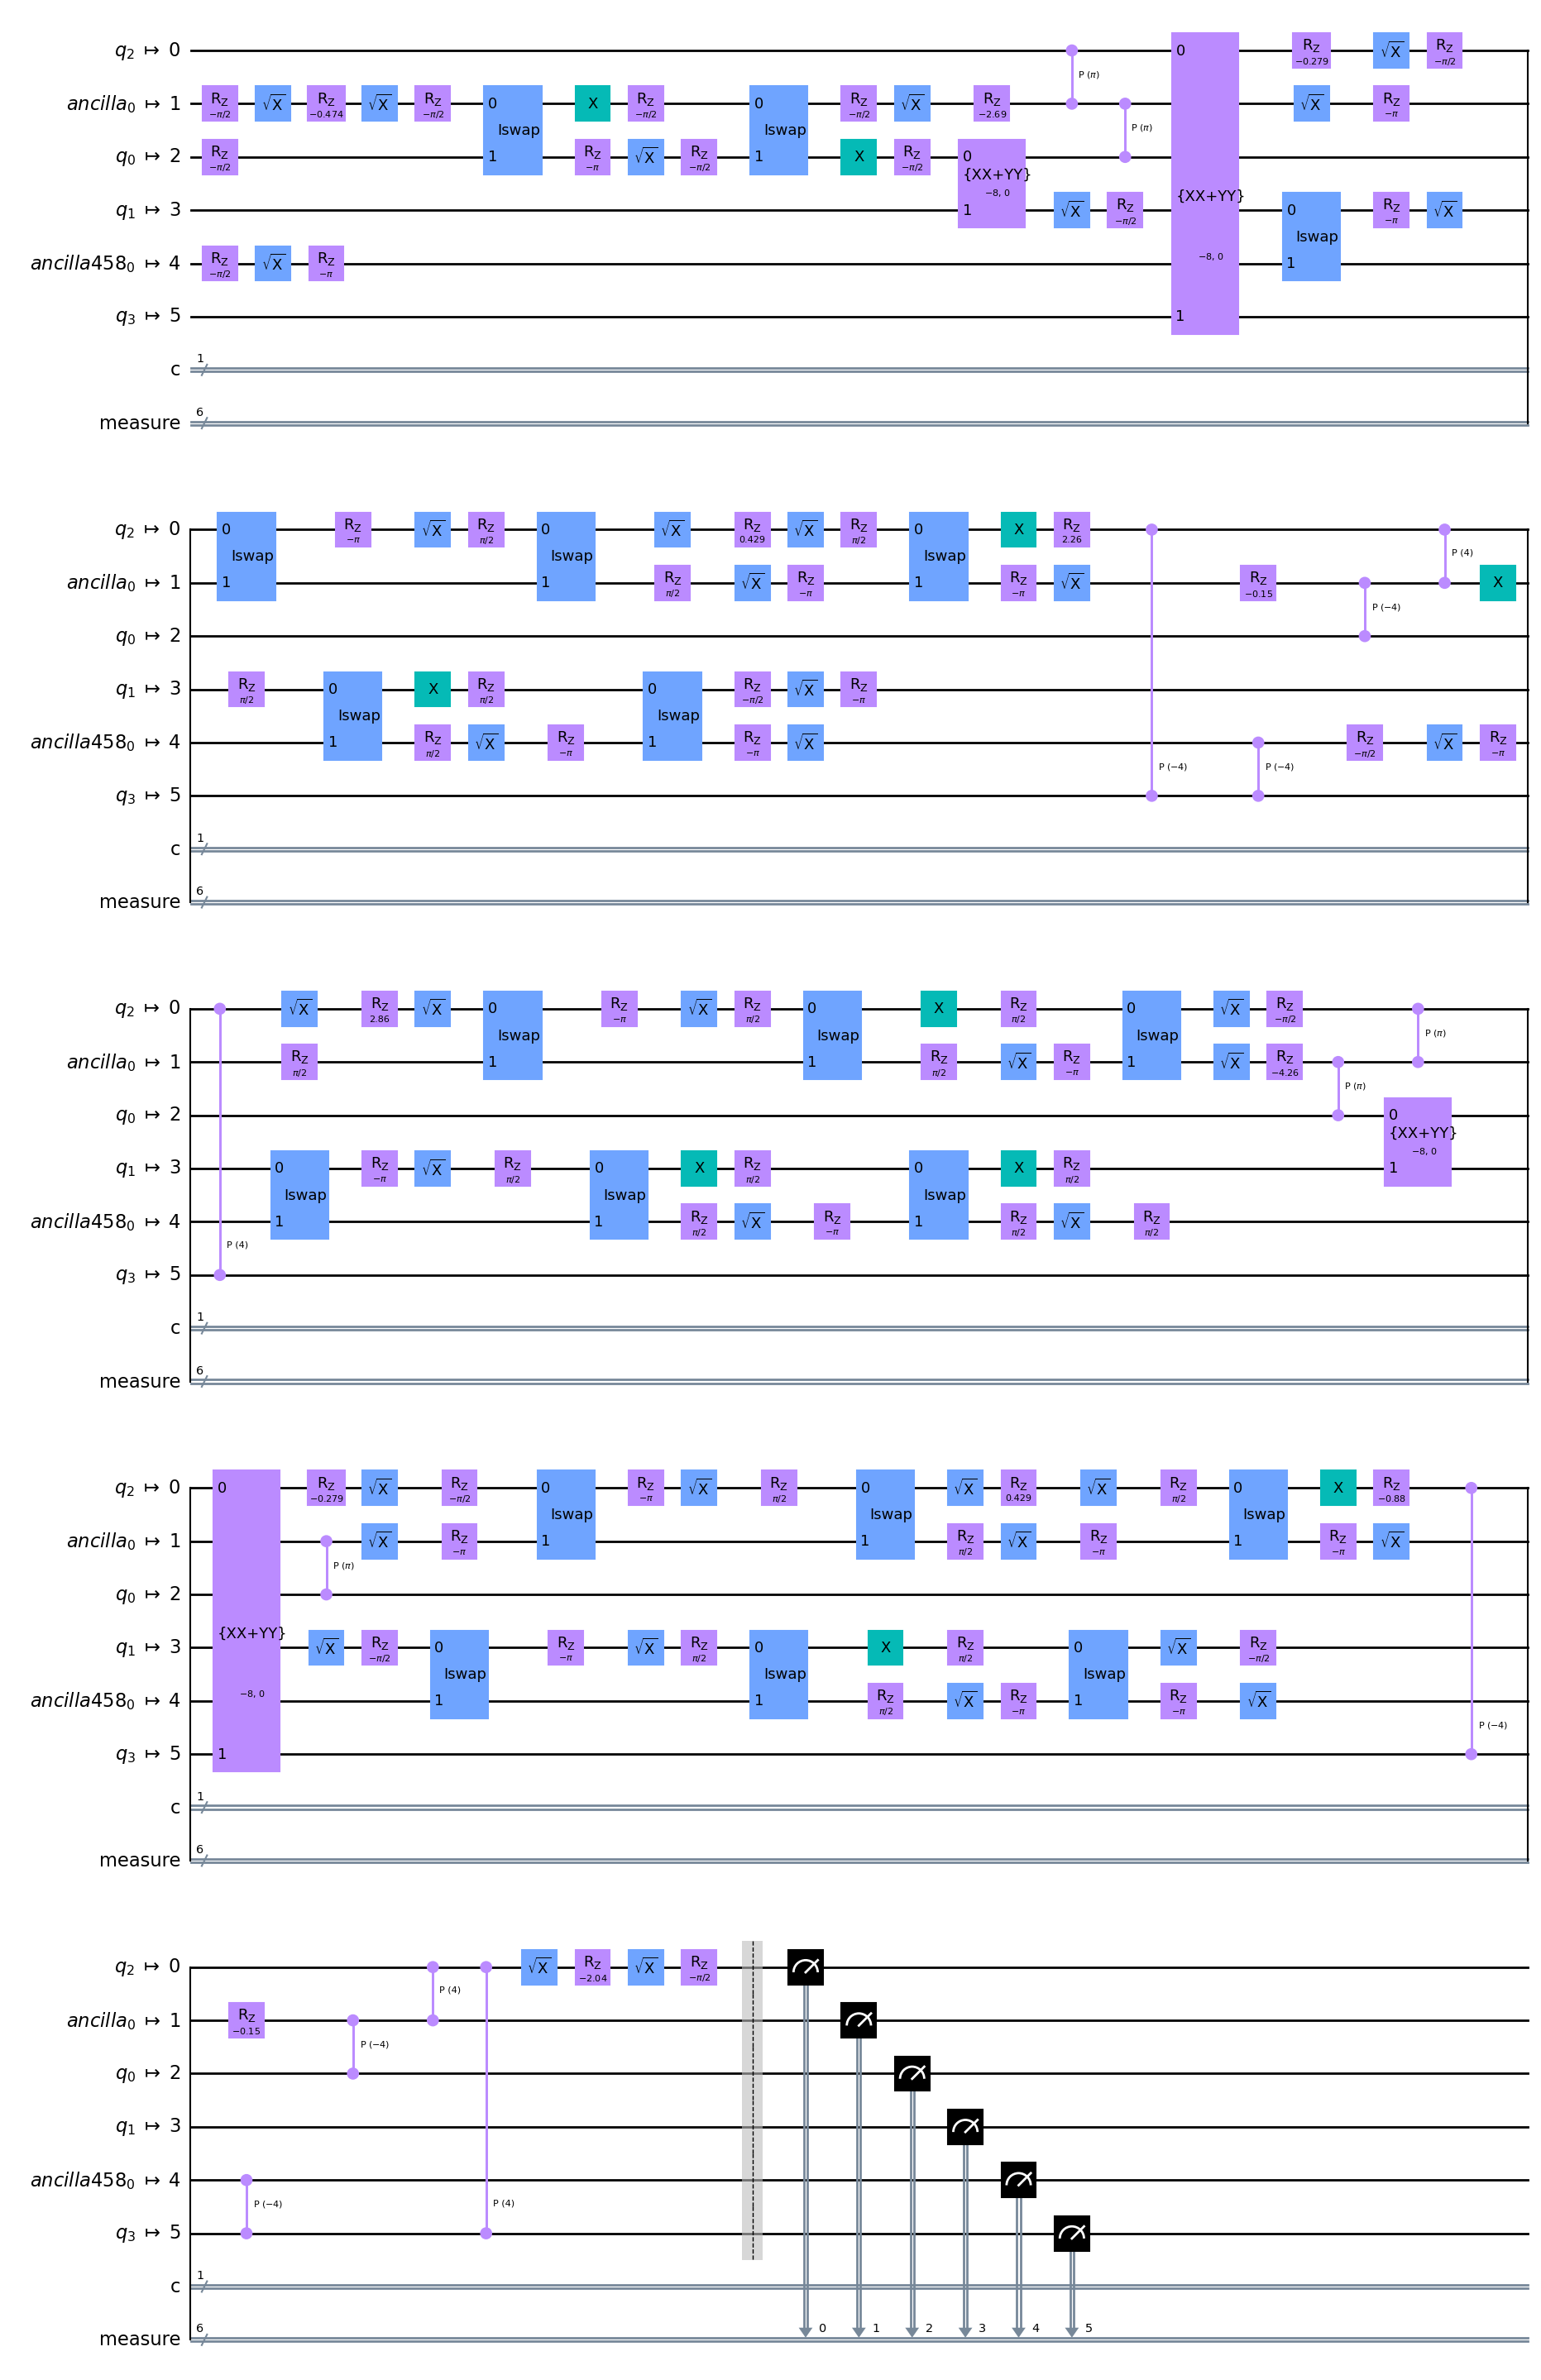

In [15]:
# Transpile to WMI hardware
test_circ = transpile(
    U_qc,
    backend=backend,
    optimization_level=3,
)
test_circ.measure_active()
test_circ.draw("mpl")

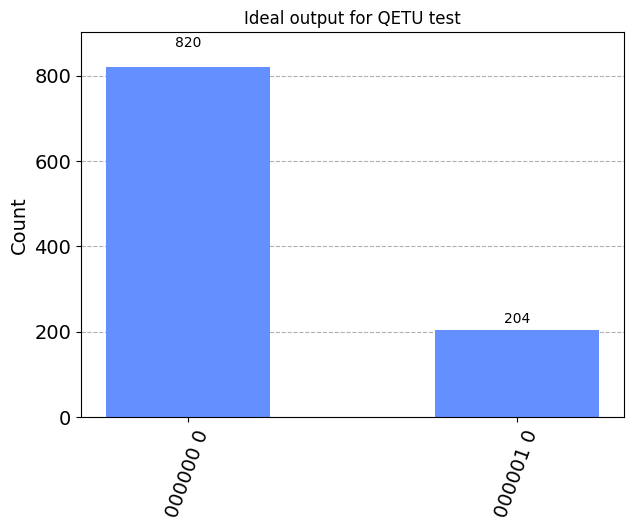

In [16]:
# Create ideal simulator backend and transpile circuit
sim_ideal = AerSimulator()
t_test_circ = transpile(test_circ, sim_ideal)

ideal_result = sim_ideal.run(t_test_circ).result()
ideal_counts = ideal_result.get_counts(0)
plot_histogram(ideal_counts,
               title='Ideal output for QETU test')

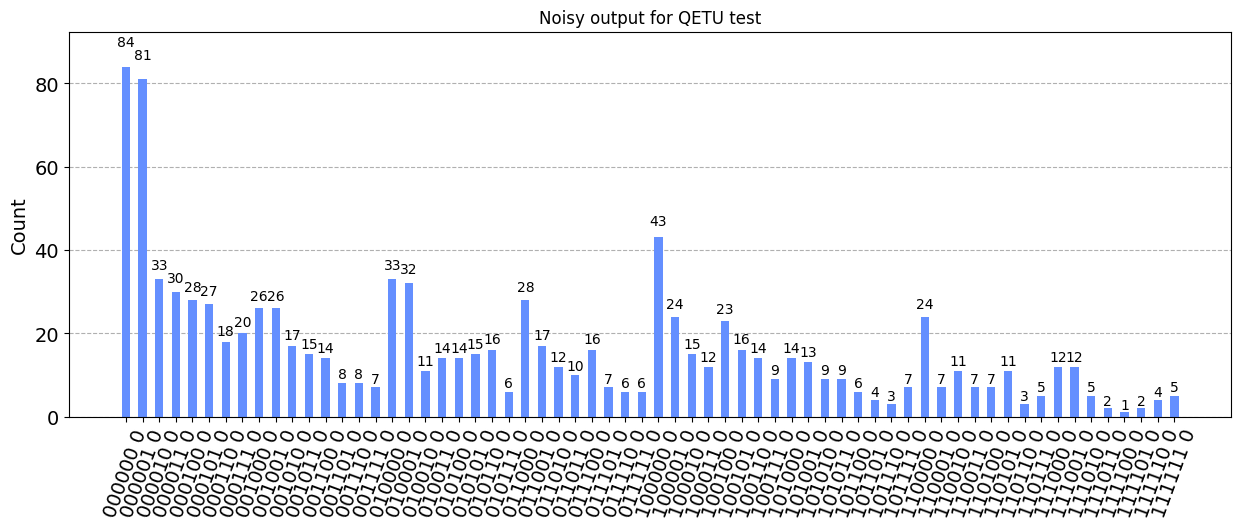

In [17]:
# Create noisy simulator and transpile circuit
wmi_backend = FakeWMI()
wmi_noise_model = NoiseModel.from_backend(wmi_backend)
wmi_noise_model.add_basis_gates(['unitary'])
sim_noise = AerSimulator(noise_model=wmi_noise_model)
test_circ = add_iswap_labels(test_circ)
test_circ = add_xx_plus_yy_labels(test_circ)
t_test_circ_noise = transpile(test_circ, sim_noise)

# Run on the simulator without noise
noise_result = sim_noise.run(t_test_circ_noise).result()
noise_counts = noise_result.get_counts(test_circ)
plot_histogram(noise_counts,
               title='Noisy output for QETU test', figsize=(15,5))

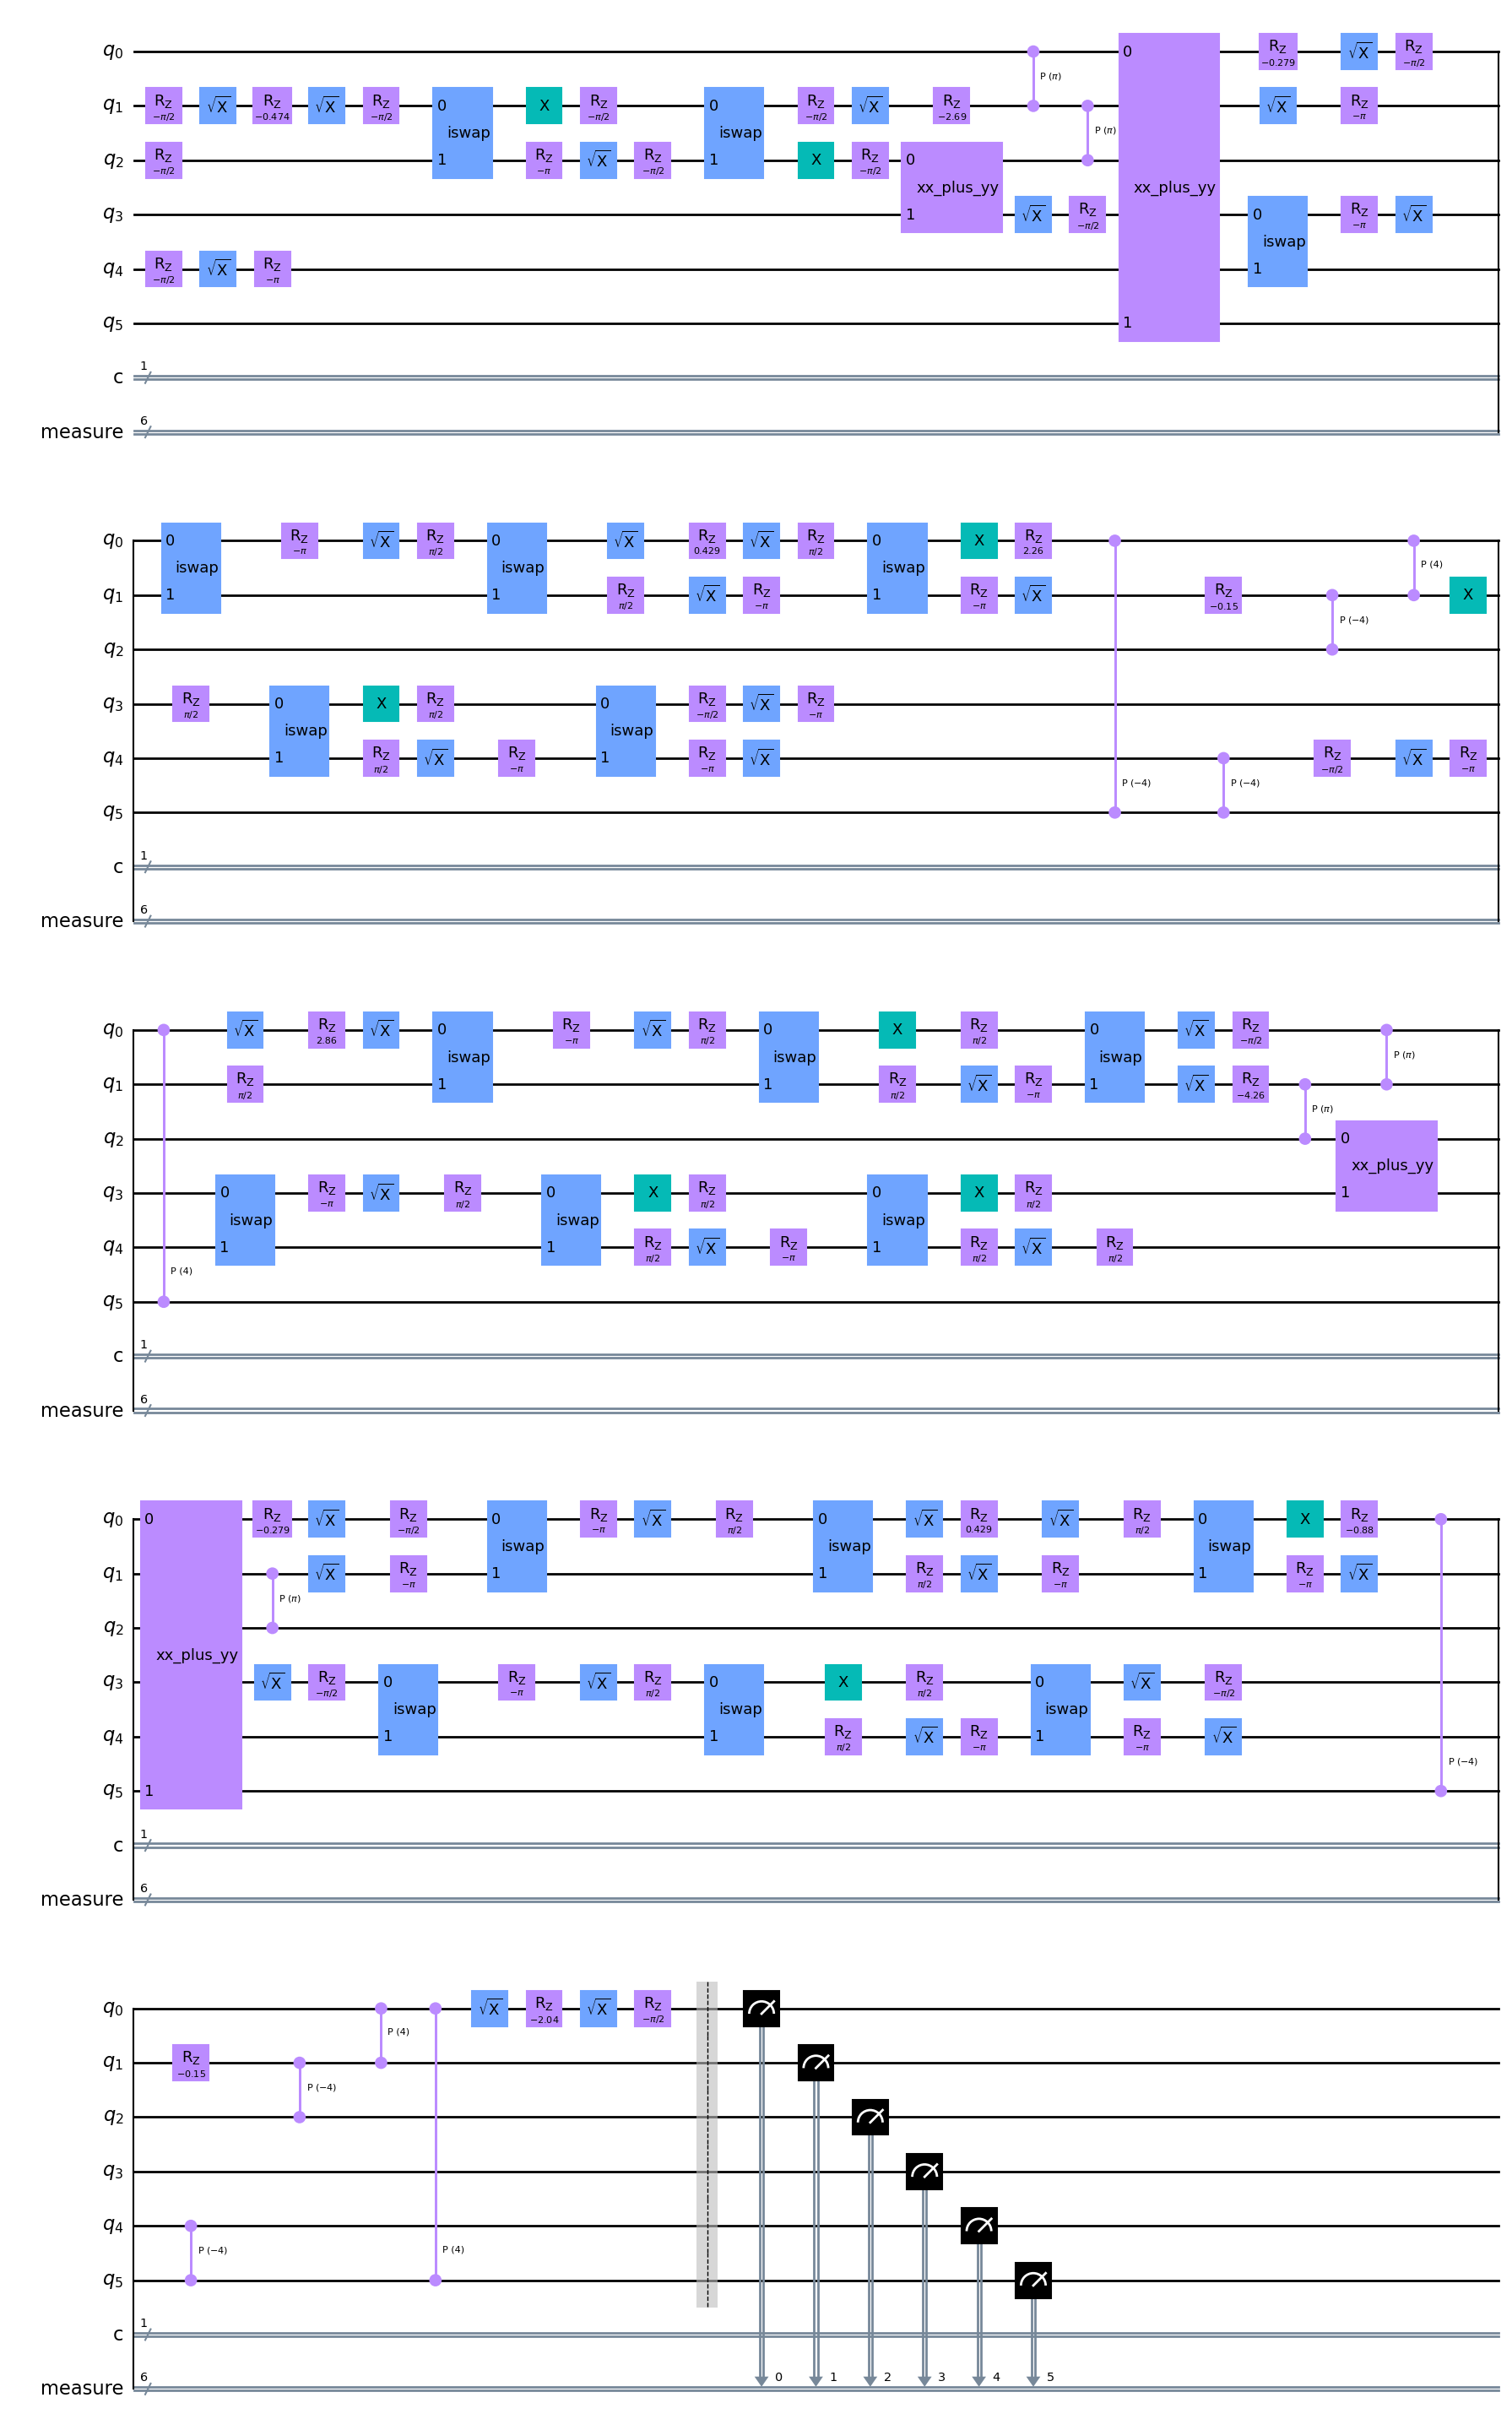

In [18]:
t_test_circ_noise.draw("mpl")

In [19]:
print(t_test_circ_noise.depth())

75
